# Gesture Recognition

In this project, we build a 3D Conv model that will be able to predict the 5 gestures correctly.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Thumbs up:  Increase the volume
Thumbs down: Decrease the volume
Left swipe: 'Jump' backwards 10 seconds
Right swipe: 'Jump' forward 10 seconds  
Stop: Pause the movie

The dataset split in train and val folders contaning the frames for different videos shot for different gestures (as listed above) have been kept at https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL

For analysing videos using neural networks, two types of architectures are used commonly. One is the standard CNN + RNN architecture in which the images of a video through a CNN is passed which extracts a feature vector for each image, and then the sequence of these feature vectors is passed through an RNN.
<br><br>
The other popular architecture used to process videos is a natural extension of CNNs - a 3D convolutional network. 
<br><br><br>
In this project, you will try both these architectures. In addition to these two, we would also be trying model based on transfer learning (preferably ones with smaller size such as MobilNet or MObilNetV2)

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

import cv2
import matplotlib.pyplot as plt
% matplotlib inline

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

train_path = 'Project_data'+ '/' + 'train'
val_path = 'Project_data'+ '/' + 'val'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
     
# this is the generator function        
def generator(frames_to_sample,source_path, folder_list, batch_size):
        # The NumPy linspace function creates sequences of evenly spaced values within a defined interval.
        img_idx = np.round(np.linspace(0,29,frames_to_sample),decimals=0).astype(int)
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size # number of batches given a batch size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= single_batch_data(source_path,t,batch,batch_size,img_idx)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size # taking the remainder as the remaining batch seq
        
            if (remaining_seq != 0):
                batch_data, batch_labels= single_batch_data(source_path,t,num_batches,batch_size,img_idx,remaining_seq)
                yield batch_data, batch_labels 
    

# this fn is called from the generator function to return the batch_data,batch_labels for a single batch     
def single_batch_data(source_path,t,batch,batch_size,img_idx,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size    
        batch_data = np.zeros((seq_len,len(img_idx),120,120,3)) 
        batch_labels = np.zeros((seq_len,5))
        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                temp = imresize(image,(120,120))
                temp = temp/127.5-1 #Normalize data
                
                # for all 3 channels
                batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1        
        return(batch_data,batch_labels)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

Next we will create a consolidated function for training the model

In [5]:
# creating a consolidated fn for training the model

def train_model(model, frames_to_sample,batch_size, num_epochs):    
        #`train_generator` and the `val_generator` which will be used in `.fit_generator`
        train_generator = generator(frames_to_sample, train_path, train_doc, batch_size)
        val_generator = generator(frames_to_sample, val_path, val_doc, batch_size)
        
        num_train_sequences = len(train_doc)
        num_val_sequences = len(val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=4, cooldown=1, verbose=1)
        
        callbacks_list = [checkpoint, LR]
        
        # The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1
    
        # This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

In [6]:
# fn for plotting the history
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, GlobalAveragePooling3D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

### Conv Model model_3d_1

In [10]:
model_3d_1 = Sequential()
model_3d_1.add(Conv3D(16, (5,5,3), padding='same',input_shape=(20,120,120,3)))
model_3d_1.add(Activation('relu'))
model_3d_1.add(BatchNormalization())
model_3d_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_1.add(Conv3D(32, (3,3,3), padding='same'))
model_3d_1.add(Activation('relu'))
model_3d_1.add(BatchNormalization())
model_3d_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_1.add(Conv3D(64, (3,3,3), padding='same'))
model_3d_1.add(Activation('relu'))
model_3d_1.add(BatchNormalization())
model_3d_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_1.add(Conv3D(128, (3,3,3), padding='same'))
model_3d_1.add(Activation('relu'))
model_3d_1.add(BatchNormalization())
model_3d_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_1.add(Flatten())
model_3d_1.add(Dense(256,activation='relu'))
model_3d_1.add(BatchNormalization())
model_3d_1.add(Dropout(0.25))

model_3d_1.add(Dense(256,activation='relu'))
model_3d_1.add(BatchNormalization())
model_3d_1.add(Dropout(0.25))


model_3d_1.add(Dense(5,activation='softmax'))


# Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, 
# you'll see the total number of parameters you have to train.
optimiser = optimizers.Adam(lr=0.001)
model_3d_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model_3d_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 120, 120, 16)  3616      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 60, 60, 32)    128       
__________

In [16]:
# def train_model(model, frames_to_sample,batch_size, num_epochs):

# batch size 40 working fine:
# batch size 80 working fine:
# batch size 100 not working fine: ResourceExhaustedError
# batch size 120 not working fine: ResourceExhaustedError

history_model_3d_1 = train_model(model_3d_1, 20,80, 30)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


9/9 [==============================] - 63s 7s/step - loss: 0.8305 - categorical_accuracy: 0.6942 - val_loss: 4.1493 - val_categorical_accuracy: 0.3300

Epoch 00001: val_loss improved from inf to 4.14935, saving model to model_init_2020-09-0307_41_10.996742/model-00001-0.84402-0.69080-4.14935-0.33000.h5
Epoch 2/30
9/9 [==============================] - 51s 6s/step - loss: 0.5811 - categorical_accuracy: 0.7747 - val_loss: 6.0729 - val_categorical_accuracy: 0.3100

Epoch 00002: val_loss did not improve from 4.14935
Epoch 3/30
9/9 [==============================] - 52s 6s/step - loss: 0.3864 - categorical_accuracy: 0.8638 - val_loss: 2.5974 - val_categorical_accuracy: 0.4300

Epoch 00003: val_loss improved from 4.14935 to 2.59741, saving model to model_init_2020-09-0307_41_10.996742/model-00003-0.39977-0.85671-2.59741-0.43000.h5
Epoch 4/30
9/9 [==============================] - 51s 6s/step - loss: 0.2573 - categorical_accuracy: 0.8955 - val_loss: 1.4916 - val_categorical_accuracy: 0.6100



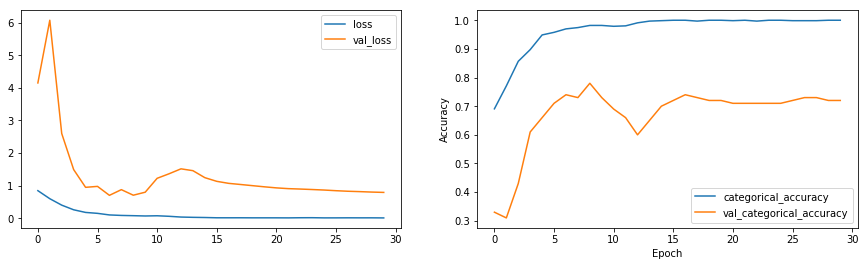

In [17]:
plot(history_model_3d_1)

#### Model conclusion:
1. The model results are as follows: val accuracy --> 0.78 corresponding training accuracy --> 0.97
2. Model is overfitting a lot, final training accuracy is 1

### Conv Model model_3d_2

In [18]:
# decreased the filter size
# increased dropout rate

model_3d_2 = Sequential()
model_3d_2.add(Conv3D(16, (2,2,2), padding='same',input_shape=(20,120,120,3)))
model_3d_2.add(Activation('relu'))
model_3d_2.add(BatchNormalization())
model_3d_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_2.add(Conv3D(32, (2,2,2), padding='same'))
model_3d_2.add(Activation('relu'))
model_3d_2.add(BatchNormalization())
model_3d_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_2.add(Conv3D(64, (2,2,2), padding='same'))
model_3d_2.add(Activation('relu'))
model_3d_2.add(BatchNormalization())
model_3d_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_2.add(Conv3D(128, (2,2,2), padding='same'))
model_3d_2.add(Activation('relu'))
model_3d_2.add(BatchNormalization())
model_3d_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_2.add(Flatten())
model_3d_2.add(Dense(256,activation='relu'))
model_3d_2.add(BatchNormalization())
model_3d_2.add(Dropout(0.5))

model_3d_2.add(Dense(256,activation='relu'))
model_3d_2.add(BatchNormalization())
model_3d_2.add(Dropout(0.5))

model_3d_2.add(Dense(5,activation='softmax'))


# Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, 
# you'll see the total number of parameters you have to train.
optimiser = optimizers.Adam(lr=0.0002)
model_3d_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model_3d_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 120, 120, 16)  400       
_________________________________________________________________
activation_5 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_6 (Activation)    (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 10, 60, 60, 32)    128       
__________

In [20]:
history_model_3d_2 = train_model(model_3d_2, 20,80, 30)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


9/9 [==============================] - 63s 7s/step - loss: 2.1622 - categorical_accuracy: 0.3153 - val_loss: 1.3402 - val_categorical_accuracy: 0.4600

Epoch 00001: val_loss improved from inf to 1.34017, saving model to model_init_2020-09-0308_14_09.522334/model-00001-2.21215-0.30618-1.34017-0.46000.h5
Epoch 2/30
9/9 [==============================] - 50s 6s/step - loss: 1.5154 - categorical_accuracy: 0.4610 - val_loss: 1.2354 - val_categorical_accuracy: 0.5500

Epoch 00002: val_loss improved from 1.34017 to 1.23544, saving model to model_init_2020-09-0308_14_09.522334/model-00002-1.52989-0.46305-1.23544-0.55000.h5
Epoch 3/30
9/9 [==============================] - 52s 6s/step - loss: 1.1821 - categorical_accuracy: 0.5757 - val_loss: 1.2184 - val_categorical_accuracy: 0.5600

Epoch 00003: val_loss improved from 1.23544 to 1.21841, saving model to model_init_2020-09-0308_14_09.522334/model-00003-1.17283-0.57315-1.21841-0.56000.h5
Epoch 4/30
9/9 [==============================] - 52s 6s/s

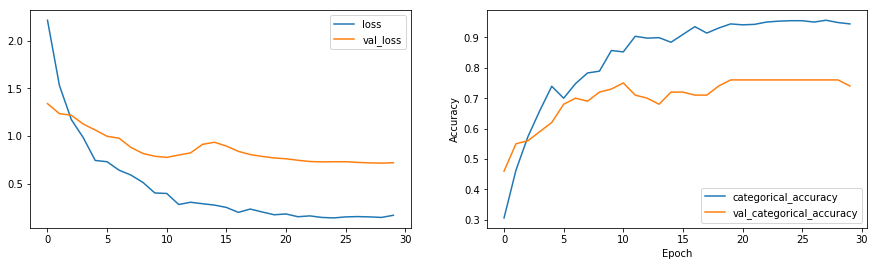

In [21]:
plot(history_model_3d_2)

#### Model conclusion:
1. The model results are as follows: val accuracy --> 0.75 corresponding training accuracy --> 0.85
2. Model is overfitting, final training accuracy is 0.94

### Conv Model model_3d_3

In [24]:
# training with lower batch size

model_3d_3 = Sequential()
model_3d_3.add(Conv3D(16, (2,2,2), padding='same',input_shape=(20,120,120,3)))
model_3d_3.add(Activation('relu'))
model_3d_3.add(BatchNormalization())
model_3d_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_3.add(Conv3D(32, (2,2,2), padding='same'))
model_3d_3.add(Activation('relu'))
model_3d_3.add(BatchNormalization())
model_3d_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_3.add(Conv3D(64, (2,2,2), padding='same'))
model_3d_3.add(Activation('relu'))
model_3d_3.add(BatchNormalization())
model_3d_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_3.add(Conv3D(128, (2,2,2), padding='same'))
model_3d_3.add(Activation('relu'))
model_3d_3.add(BatchNormalization())
model_3d_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_3.add(Flatten())
model_3d_3.add(Dense(256,activation='relu'))
model_3d_3.add(BatchNormalization())
model_3d_3.add(Dropout(0.5))

model_3d_3.add(Dense(256,activation='relu'))
model_3d_3.add(BatchNormalization())
model_3d_3.add(Dropout(0.5))

model_3d_3.add(Dense(5,activation='softmax'))


# Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, 
# you'll see the total number of parameters you have to train.
optimiser = optimizers.Adam(lr=0.0002)
model_3d_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model_3d_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 20, 120, 120, 16)  400       
_________________________________________________________________
activation_25 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_26 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 10, 60, 60, 32)    128       
__________

In [25]:
history_model_3d_3 = train_model(model_3d_3,20,40,20)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


17/17 [==============================] - 60s 4s/step - loss: 2.3124 - categorical_accuracy: 0.2874 - val_loss: 1.5553 - val_categorical_accuracy: 0.4200

Epoch 00001: val_loss improved from inf to 1.55535, saving model to model_init_2020-09-0711_43_38.495839/model-00001-2.32229-0.28808-1.55535-0.42000.h5
Epoch 2/20
17/17 [==============================] - 48s 3s/step - loss: 1.4045 - categorical_accuracy: 0.5144 - val_loss: 1.1723 - val_categorical_accuracy: 0.5800

Epoch 00002: val_loss improved from 1.55535 to 1.17232, saving model to model_init_2020-09-0711_43_38.495839/model-00002-1.39476-0.51735-1.17232-0.58000.h5
Epoch 3/20
17/17 [==============================] - 52s 3s/step - loss: 1.2150 - categorical_accuracy: 0.5468 - val_loss: 0.9361 - val_categorical_accuracy: 0.6700

Epoch 00003: val_loss improved from 1.17232 to 0.93609, saving model to model_init_2020-09-0711_43_38.495839/model-00003-1.21242-0.55053-0.93609-0.67000.h5
Epoch 4/20
17/17 [==============================] - 

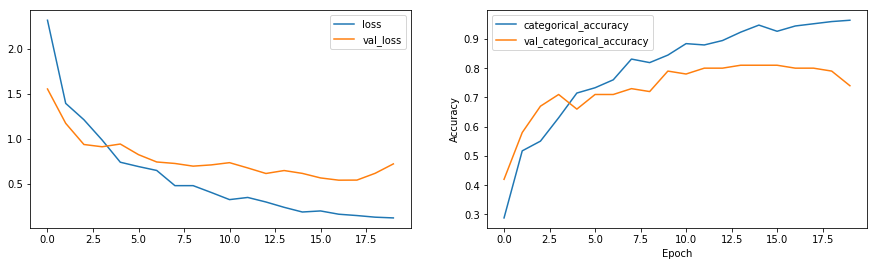

In [26]:
plot(history_model_3d_3)

#### Model conclusion:
1. The model results are as follows: val accuracy --> 0.80 corresponding training accuracy --> 0.87
2. We have much better results in this case slight overfitting is there but we can ignore that for now

### Conv Model model_3d_4

In [40]:
# added a small additional dropout to the last conv layer post max pooling

model_3d_4 = Sequential()
model_3d_4.add(Conv3D(16, (2,2,2), padding='same',input_shape=(16,120,120,3)))
model_3d_4.add(Activation('relu'))
model_3d_4.add(BatchNormalization())
model_3d_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_4.add(Conv3D(32, (2,2,2), padding='same'))
model_3d_4.add(Activation('relu'))
model_3d_4.add(BatchNormalization())
model_3d_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_4.add(Conv3D(64, (2,2,2), padding='same'))
model_3d_4.add(Activation('relu'))
model_3d_4.add(BatchNormalization())
model_3d_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_4.add(Conv3D(128, (2,2,2), padding='same'))
model_3d_4.add(Activation('relu'))
model_3d_4.add(BatchNormalization())
model_3d_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3d_4.add(Dropout(0.2))

model_3d_4.add(Flatten())
model_3d_4.add(Dense(256,activation='relu'))
model_3d_4.add(BatchNormalization())
model_3d_4.add(Dropout(0.5))

model_3d_4.add(Dense(256,activation='relu'))
model_3d_4.add(BatchNormalization())
model_3d_4.add(Dropout(0.5))

model_3d_4.add(Dense(5,activation='softmax'))


# Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, 
# you'll see the total number of parameters you have to train.
optimiser = optimizers.Adam(lr=0.0002)
model_3d_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model_3d_4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_53 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_53 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_81 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_53 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_54 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_82 (Batc (None, 8, 60, 60, 32)     128       
__________

In [41]:
history_model_3d_4 = train_model(model_3d_4,16,40,20)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


17/17 [==============================] - 48s 3s/step - loss: 2.2011 - categorical_accuracy: 0.3073 - val_loss: 1.4140 - val_categorical_accuracy: 0.4200

Epoch 00001: val_loss improved from inf to 1.41400, saving model to model_init_2020-09-0713_38_38.999469/model-00001-2.20860-0.30317-1.41400-0.42000.h5
Epoch 2/20
17/17 [==============================] - 35s 2s/step - loss: 1.6168 - categorical_accuracy: 0.4742 - val_loss: 1.1734 - val_categorical_accuracy: 0.5100

Epoch 00002: val_loss improved from 1.41400 to 1.17338, saving model to model_init_2020-09-0713_38_38.999469/model-00002-1.61660-0.47511-1.17338-0.51000.h5
Epoch 3/20
17/17 [==============================] - 42s 2s/step - loss: 1.3214 - categorical_accuracy: 0.5370 - val_loss: 0.9570 - val_categorical_accuracy: 0.6100

Epoch 00003: val_loss improved from 1.17338 to 0.95695, saving model to model_init_2020-09-0713_38_38.999469/model-00003-1.32719-0.53846-0.95695-0.61000.h5
Epoch 4/20
17/17 [==============================] - 

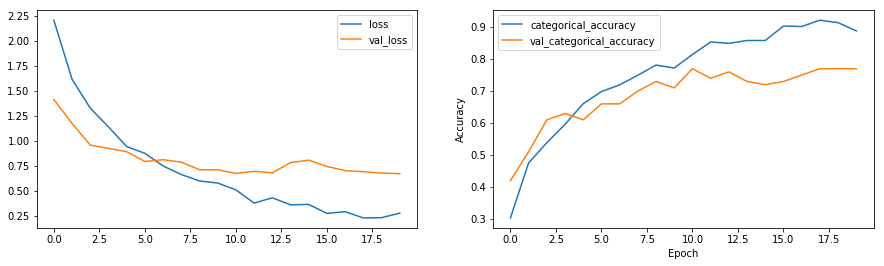

In [42]:
plot(history_model_3d_4)

#### Model conclusion:
1. The model results are as follows: val accuracy --> 0.77 corresponding training accuracy --> 0.81
2. Overfitting has reduced compared to the previous model but the validation accuracy has decreased too

### Conv Model model_3d_5

In [8]:
# removed the dense layers and added a Global average pooling layer
# this reduced the parameters to only 88K almost 50% reduction in the number of parameters

model_3d_5 = Sequential()
model_3d_5.add(Conv3D(16, (2,2,2), padding='same',input_shape=(20,120,120,3)))
model_3d_5.add(Activation('relu'))
model_3d_5.add(BatchNormalization())
model_3d_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_5.add(Conv3D(32, (2,2,2), padding='same'))
model_3d_5.add(Activation('relu'))
model_3d_5.add(BatchNormalization())
model_3d_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_5.add(Conv3D(64, (2,2,2), padding='same'))
model_3d_5.add(Activation('relu'))
model_3d_5.add(BatchNormalization())
model_3d_5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3d_5.add(Dropout(0.25))

model_3d_5.add(Conv3D(128, (2,2,2), padding='same'))
model_3d_5.add(Activation('relu'))
model_3d_5.add(BatchNormalization())
model_3d_5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3d_5.add(Dropout(0.25))

model_3d_5.add(GlobalAveragePooling3D())
model_3d_5.add(Dense(5, activation='softmax'))


# Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, 
# you'll see the total number of parameters you have to train.
optimiser = optimizers.Adam(lr=0.0002)
model_3d_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model_3d_5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 120, 120, 16)  400       
_________________________________________________________________
activation_1 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 60, 60, 32)    128       
__________

In [9]:
history_model_3d_5 = train_model(model_3d_5,20,80,40)

Epoch 1/40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


9/9 [==============================] - 166s 18s/step - loss: 1.4914 - categorical_accuracy: 0.3751 - val_loss: 1.3521 - val_categorical_accuracy: 0.4300

Epoch 00001: val_loss improved from inf to 1.35215, saving model to model_init_2020-09-1104_38_52.246934/model-00001-1.51237-0.36048-1.35215-0.43000.h5
Epoch 2/40
9/9 [==============================] - 51s 6s/step - loss: 1.1357 - categorical_accuracy: 0.5039 - val_loss: 1.3309 - val_categorical_accuracy: 0.4100

Epoch 00002: val_loss improved from 1.35215 to 1.33093, saving model to model_init_2020-09-1104_38_52.246934/model-00002-1.14987-0.49925-1.33093-0.41000.h5
Epoch 3/40
9/9 [==============================] - 51s 6s/step - loss: 1.0420 - categorical_accuracy: 0.5533 - val_loss: 1.2677 - val_categorical_accuracy: 0.4400

Epoch 00003: val_loss improved from 1.33093 to 1.26775, saving model to model_init_2020-09-1104_38_52.246934/model-00003-1.04357-0.54902-1.26775-0.44000.h5
Epoch 4/40
9/9 [==============================] - 52s 6s

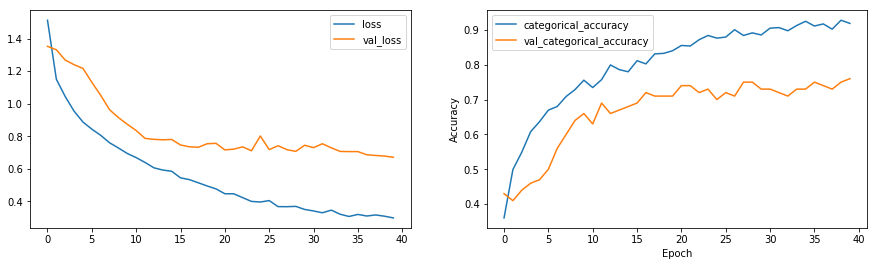

In [13]:
plot(history_model_3d_5)

#### Model conclusion:
1. The model results are as follows: val accuracy --> 0.75 corresponding training accuracy --> 0.88
2. Model is overfitting but the results are good considering to the number of parameters

In [8]:
# same as model 4
# higher batch size and more epochs, lower dropout

model_3d_6 = Sequential()
model_3d_6.add(Conv3D(16, (2,2,2), padding='same',input_shape=(16,120,120,3)))
model_3d_6.add(Activation('relu'))
model_3d_6.add(BatchNormalization())
model_3d_6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_6.add(Conv3D(32, (2,2,2), padding='same'))
model_3d_6.add(Activation('relu'))
model_3d_6.add(BatchNormalization())
model_3d_6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_6.add(Conv3D(64, (2,2,2), padding='same'))
model_3d_6.add(Activation('relu'))
model_3d_6.add(BatchNormalization())
model_3d_6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3d_6.add(Conv3D(128, (2,2,2), padding='same'))
model_3d_6.add(Activation('relu'))
model_3d_6.add(BatchNormalization())
model_3d_6.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3d_6.add(Dropout(0.1))

model_3d_6.add(Flatten())
model_3d_6.add(Dense(256,activation='relu'))
model_3d_6.add(BatchNormalization())
model_3d_6.add(Dropout(0.5))

model_3d_6.add(Dense(256,activation='relu'))
model_3d_6.add(BatchNormalization())
model_3d_6.add(Dropout(0.5))

model_3d_6.add(Dense(5,activation='softmax'))


# Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, 
# you'll see the total number of parameters you have to train.
optimiser = optimizers.Adam(lr=0.0002)
model_3d_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model_3d_6.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 60, 60, 32)     128       
__________

In [9]:
history_model_3d_6 = train_model(model_3d_6,16,80,30)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


9/9 [==============================] - 141s 16s/step - loss: 2.4675 - categorical_accuracy: 0.2526 - val_loss: 1.6659 - val_categorical_accuracy: 0.3600

Epoch 00001: val_loss improved from inf to 1.66590, saving model to model_init_2020-09-1111_31_32.693285/model-00001-2.52680-0.23529-1.66590-0.36000.h5
Epoch 2/30
9/9 [==============================] - 46s 5s/step - loss: 1.5905 - categorical_accuracy: 0.4204 - val_loss: 1.2884 - val_categorical_accuracy: 0.4900

Epoch 00002: val_loss improved from 1.66590 to 1.28840, saving model to model_init_2020-09-1111_31_32.693285/model-00002-1.61772-0.41931-1.28840-0.49000.h5
Epoch 3/30
9/9 [==============================] - 52s 6s/step - loss: 1.3064 - categorical_accuracy: 0.5199 - val_loss: 1.0936 - val_categorical_accuracy: 0.5500

Epoch 00003: val_loss improved from 1.28840 to 1.09361, saving model to model_init_2020-09-1111_31_32.693285/model-00003-1.25205-0.52640-1.09361-0.55000.h5
Epoch 4/30
9/9 [==============================] - 51s 6s

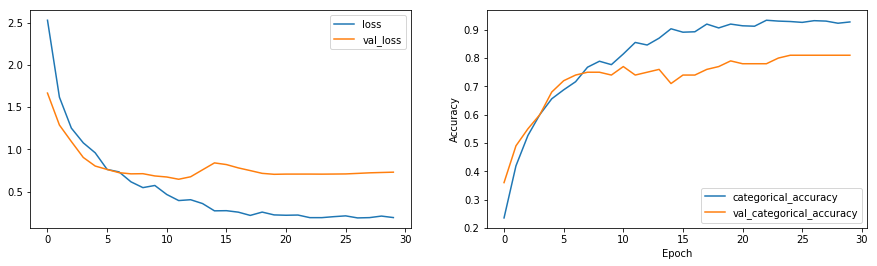

In [10]:
plot(history_model_3d_6)

#### Model conclusion:
1. The model results are as follows: val accuracy --> 0.81 corresponding training accuracy --> 0.93
2. Model is overfitting

# CNN + LSTM

### CNN_LSTM Model : model_cnn_lstm_1

Lstm_Cells = 64, Dense_Neurons = 64, Dropout for last two layers = 0.25

In [13]:
model_cnn_lstm_1 = Sequential()

model_cnn_lstm_1.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(20,120,120,3)))
model_cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_1.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_1.add(TimeDistributed(Flatten()))

lstm_cells=64
dense_neurons=64
dropout=0.25
model_cnn_lstm_1.add(LSTM(lstm_cells))
model_cnn_lstm_1.add(Dropout(dropout))

model_cnn_lstm_1.add(Dense(dense_neurons,activation='relu'))
model_cnn_lstm_1.add(Dropout(dropout))

model_cnn_lstm_1.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model_cnn_lstm_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model_cnn_lstm_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_33 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_34 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_35 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_37 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 20, 30, 30, 64)    18496     
__________

In [14]:
history_model_cnn_lstm_1 = train_model(model_cnn_lstm_1, 20,80, 30)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


9/9 [==============================] - 168s 19s/step - loss: 1.5362 - categorical_accuracy: 0.3027 - val_loss: 1.3912 - val_categorical_accuracy: 0.4500

Epoch 00001: val_loss improved from inf to 1.39122, saving model to model_init_2020-09-0316_32_50.723677/model-00001-1.54852-0.29261-1.39122-0.45000.h5
Epoch 2/30
9/9 [==============================] - 50s 6s/step - loss: 1.2846 - categorical_accuracy: 0.4756 - val_loss: 1.2733 - val_categorical_accuracy: 0.4500

Epoch 00002: val_loss improved from 1.39122 to 1.27329, saving model to model_init_2020-09-0316_32_50.723677/model-00002-1.29213-0.47210-1.27329-0.45000.h5
Epoch 3/30
9/9 [==============================] - 53s 6s/step - loss: 1.1305 - categorical_accuracy: 0.5488 - val_loss: 1.3405 - val_categorical_accuracy: 0.4400

Epoch 00003: val_loss did not improve from 1.27329
Epoch 4/30
9/9 [==============================] - 52s 6s/step - loss: 1.0608 - categorical_accuracy: 0.5816 - val_loss: 1.2564 - val_categorical_accuracy: 0.4500

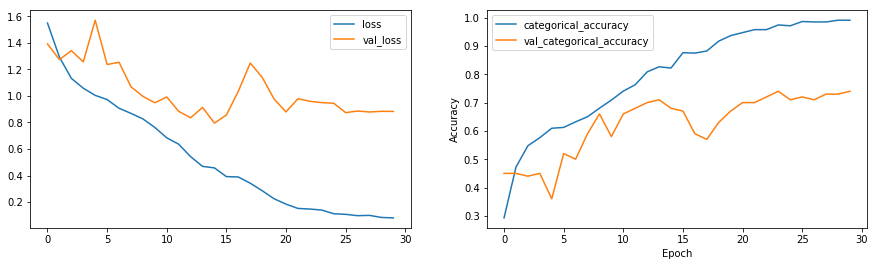

In [15]:
plot(history_model_cnn_lstm_1)

#### Model Conclusion:
Best Validation Accuracy: 71% <br>
Corresponding Training Accuracy: 82%

### CNN_LSTM Model model_cnn_lstm_2

In order to reduce the number of parameters, lets try reducing Lstm Cells by half to 32<br>
Lstm_Cells = 32, Dense_Neurons = 64, Dropout for last two layers = 0.25

In [16]:
model_cnn_lstm_2 = Sequential()

model_cnn_lstm_2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(20,120,120,3)))
model_cnn_lstm_2.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_2.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_2.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_2.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_2.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_2.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_2.add(TimeDistributed(Flatten()))

lstm_cells=32
dense_neurons=64
dropout=0.25
model_cnn_lstm_2.add(LSTM(lstm_cells))
model_cnn_lstm_2.add(Dropout(dropout))

model_cnn_lstm_2.add(Dense(dense_neurons,activation='relu'))
model_cnn_lstm_2.add(Dropout(dropout))

model_cnn_lstm_2.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model_cnn_lstm_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model_cnn_lstm_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_49 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_50 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_51 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_52 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_53 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_54 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_55 (TimeDis (None, 20, 30, 30, 64)    18496     
__________

In [17]:
history_model_cnn_lstm_2 = train_model(model_cnn_lstm_2, 20,80, 30)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


9/9 [==============================] - 63s 7s/step - loss: 1.5815 - categorical_accuracy: 0.2654 - val_loss: 1.4531 - val_categorical_accuracy: 0.3100

Epoch 00001: val_loss improved from inf to 1.45305, saving model to model_init_2020-09-0317_03_37.073743/model-00001-1.57450-0.26244-1.45305-0.31000.h5
Epoch 2/30
9/9 [==============================] - 50s 6s/step - loss: 1.4275 - categorical_accuracy: 0.3863 - val_loss: 1.3790 - val_categorical_accuracy: 0.4300

Epoch 00002: val_loss improved from 1.45305 to 1.37904, saving model to model_init_2020-09-0317_03_37.073743/model-00002-1.43311-0.37255-1.37904-0.43000.h5
Epoch 3/30
9/9 [==============================] - 52s 6s/step - loss: 1.3655 - categorical_accuracy: 0.4456 - val_loss: 1.4405 - val_categorical_accuracy: 0.3600

Epoch 00003: val_loss did not improve from 1.37904
Epoch 4/30
9/9 [==============================] - 53s 6s/step - loss: 1.2950 - categorical_accuracy: 0.4613 - val_loss: 1.2976 - val_categorical_accuracy: 0.4700



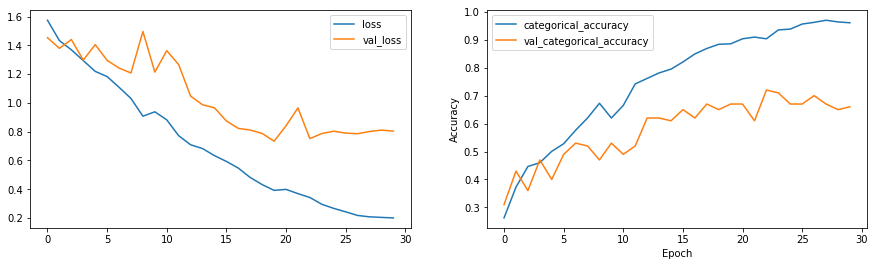

In [18]:
plot(history_model_cnn_lstm_2)

#### Model Conclusion:
Maxm Validation Accuracy: 72% <br>
Corresponding Training Accuracy: 89.8%

### CNN_LSTM Model : model_cnn_lstm_3

Increased Lstm Cells to 128, Dense_Neurons to 128<br>
Lstm_Cells = 128, Dense_Neurons = 128, Dropout = 0.5

In [19]:
model_cnn_lstm_3 = Sequential()

model_cnn_lstm_3.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(20,120,120,3)))
model_cnn_lstm_3.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_3.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_3.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_3.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_3.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_3.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_3.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_3.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_3.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_3.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_3.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_3.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_3.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_3.add(TimeDistributed(Flatten()))

lstm_cells=128
dense_neurons=128
dropout=0.5
model_cnn_lstm_3.add(LSTM(lstm_cells))
model_cnn_lstm_3.add(Dropout(dropout))

model_cnn_lstm_3.add(Dense(dense_neurons,activation='relu'))
model_cnn_lstm_3.add(Dropout(dropout))

model_cnn_lstm_3.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model_cnn_lstm_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model_cnn_lstm_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_65 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_66 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_67 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_68 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_69 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_70 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_71 (TimeDis (None, 20, 30, 30, 64)    18496     
__________

In [20]:
history_model_cnn_lstm_3 = train_model(model_cnn_lstm_3, 20,80, 30)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


9/9 [==============================] - 61s 7s/step - loss: 1.6547 - categorical_accuracy: 0.2842 - val_loss: 1.4871 - val_categorical_accuracy: 0.3400

Epoch 00001: val_loss improved from inf to 1.48712, saving model to model_init_2020-09-0317_31_07.064081/model-00001-1.66882-0.27602-1.48712-0.34000.h5
Epoch 2/30
9/9 [==============================] - 48s 5s/step - loss: 1.4507 - categorical_accuracy: 0.3814 - val_loss: 1.4181 - val_categorical_accuracy: 0.3900

Epoch 00002: val_loss improved from 1.48712 to 1.41815, saving model to model_init_2020-09-0317_31_07.064081/model-00002-1.43783-0.39065-1.41815-0.39000.h5
Epoch 3/30
9/9 [==============================] - 50s 6s/step - loss: 1.3636 - categorical_accuracy: 0.4090 - val_loss: 1.4280 - val_categorical_accuracy: 0.3100

Epoch 00003: val_loss did not improve from 1.41815
Epoch 4/30
9/9 [==============================] - 51s 6s/step - loss: 1.3054 - categorical_accuracy: 0.4613 - val_loss: 1.3448 - val_categorical_accuracy: 0.4000



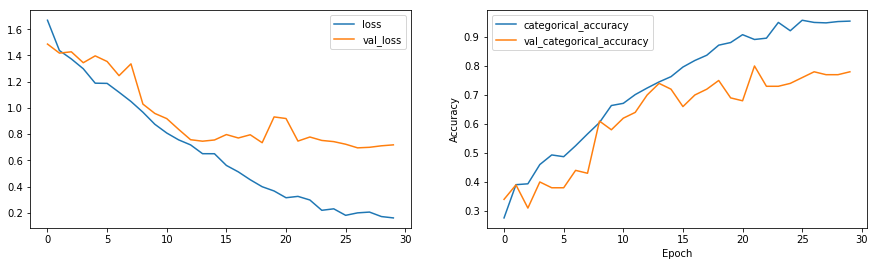

In [21]:
plot(history_model_cnn_lstm_3)

#### Model Conclusion:
Maxm Validation Accuracy: 80% <br>
Corresponding Training Accuracy: 89.3%

### CNN_LSTM Model model_cnn_lstm_4

Increased Lstm Cells to 128, Dense_Neurons to 64<br>
Lstm_Cells = 128, Dense_Neurons = 64, Dropout = 0.35

In [8]:
model_cnn_lstm_4 = Sequential()

model_cnn_lstm_4.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(20,120,120,3)))
model_cnn_lstm_4.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_4.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_4.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_4.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_4.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_4.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_4.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_4.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_4.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_4.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_4.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_4.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_4.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_4.add(TimeDistributed(Flatten()))

lstm_cells=128
dense_neurons=64
dropout=0.35
model_cnn_lstm_4.add(LSTM(lstm_cells))
model_cnn_lstm_4.add(Dropout(dropout))

model_cnn_lstm_4.add(Dense(dense_neurons,activation='relu'))
model_cnn_lstm_4.add(Dropout(dropout))

model_cnn_lstm_4.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model_cnn_lstm_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model_cnn_lstm_4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 30, 30, 64)    18496     
__________

In [9]:
history_model_cnn_lstm_4 = train_model(model_cnn_lstm_4, 20,80, 25)

Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


9/9 [==============================] - 156s 17s/step - loss: 1.5884 - categorical_accuracy: 0.2999 - val_loss: 1.3956 - val_categorical_accuracy: 0.4100

Epoch 00001: val_loss improved from inf to 1.39557, saving model to model_init_2020-09-0418_28_02.125753/model-00001-1.58476-0.30618-1.39557-0.41000.h5
Epoch 2/25
9/9 [==============================] - 61s 7s/step - loss: 1.3436 - categorical_accuracy: 0.4187 - val_loss: 1.2852 - val_categorical_accuracy: 0.4600

Epoch 00002: val_loss improved from 1.39557 to 1.28519, saving model to model_init_2020-09-0418_28_02.125753/model-00002-1.35166-0.42081-1.28519-0.46000.h5
Epoch 3/25
9/9 [==============================] - 62s 7s/step - loss: 1.1766 - categorical_accuracy: 0.5404 - val_loss: 1.1860 - val_categorical_accuracy: 0.5200

Epoch 00003: val_loss improved from 1.28519 to 1.18599, saving model to model_init_2020-09-0418_28_02.125753/model-00003-1.18439-0.53846-1.18599-0.52000.h5
Epoch 4/25
9/9 [==============================] - 51s 6s

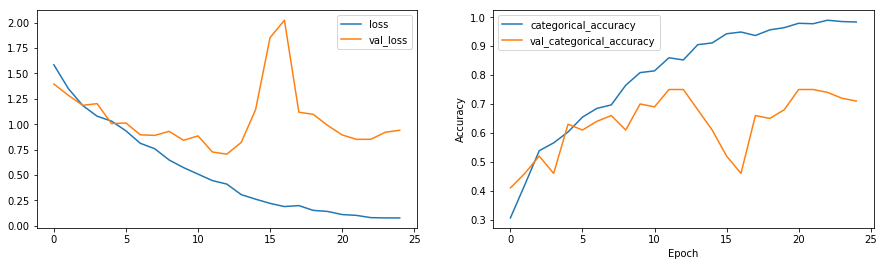

In [10]:
plot(history_model_cnn_lstm_4)

#### Model Conclusion:
Maxm Validation Accuracy: 75% <br>
Corresponding Training Accuracy: 85%

### CNN_LSTM Model : model_cnn_lstm_5

Lets add another layer

In [11]:
model_cnn_lstm_5 = Sequential()

model_cnn_lstm_5.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(20,120,120,3)))
model_cnn_lstm_5.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_5.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_5.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_5.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_5.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_5.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_5.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_5.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_5.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
model_cnn_lstm_5.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_5.add(TimeDistributed(Flatten()))

lstm_cells=64
dense_neurons=64
dropout=0.25
model_cnn_lstm_5.add(LSTM(lstm_cells))
model_cnn_lstm_5.add(Dropout(dropout))

model_cnn_lstm_5.add(Dense(dense_neurons,activation='relu'))
model_cnn_lstm_5.add(Dropout(dropout))

model_cnn_lstm_5.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model_cnn_lstm_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model_cnn_lstm_5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 20, 30, 30, 64)    18496     
__________

In [12]:
history_model_cnn_lstm_5 = train_model(model_cnn_lstm_5, 20,80, 30)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


9/9 [==============================] - 62s 7s/step - loss: 1.5428 - categorical_accuracy: 0.2957 - val_loss: 1.4910 - val_categorical_accuracy: 0.3300

Epoch 00001: val_loss improved from inf to 1.49104, saving model to model_init_2020-09-0418_52_03.672142/model-00001-1.54084-0.30166-1.49104-0.33000.h5
Epoch 2/30
9/9 [==============================] - 49s 5s/step - loss: 1.2601 - categorical_accuracy: 0.4719 - val_loss: 1.6625 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss did not improve from 1.49104
Epoch 3/30
9/9 [==============================] - 52s 6s/step - loss: 1.1111 - categorical_accuracy: 0.5597 - val_loss: 1.4912 - val_categorical_accuracy: 0.3900

Epoch 00003: val_loss did not improve from 1.49104
Epoch 4/30
9/9 [==============================] - 52s 6s/step - loss: 1.0039 - categorical_accuracy: 0.5903 - val_loss: 1.1964 - val_categorical_accuracy: 0.5500

Epoch 00004: val_loss improved from 1.49104 to 1.19640, saving model to model_init_2020-09-0418_52_03.672

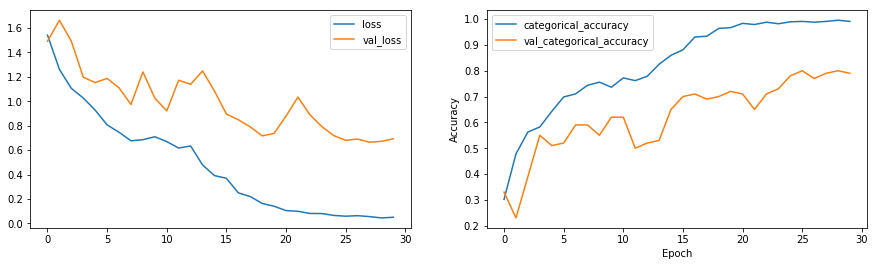

In [13]:
plot(history_model_cnn_lstm_5)

#### Model Conclusion:
Maxm Validation Accuracy: 80% <br>
Corresponding Training Accuracy: 99.58%

Adding an extra layer with reduced Lstm cells did improve validation accuracy but the model is very much overfitting.

### CNN_LSTM Model : model_cnn_lstm_6

In [9]:
model_cnn_lstm_6 = Sequential()

model_cnn_lstm_6.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(20,120,120,3)))
model_cnn_lstm_6.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_6.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_6.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_6.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_6.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_6.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_6.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_6.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_6.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_6.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_6.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_6.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_6.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_6.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_6.add(TimeDistributed(Flatten()))

lstm_cells=64
dense_neurons=32
dropout=0.1
model_cnn_lstm_6.add(LSTM(lstm_cells))
model_cnn_lstm_6.add(Dropout(dropout))

model_cnn_lstm_6.add(Dense(dense_neurons,activation='relu'))
model_cnn_lstm_6.add(Dropout(dropout))

model_cnn_lstm_6.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model_cnn_lstm_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model_cnn_lstm_6.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 30, 30, 64)    18496     
__________

In [10]:
history_model_cnn_lstm_6 = train_model(model_cnn_lstm_6, 20,80, 30)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


9/9 [==============================] - 161s 18s/step - loss: 1.5489 - categorical_accuracy: 0.3106 - val_loss: 1.3778 - val_categorical_accuracy: 0.3900

Epoch 00001: val_loss improved from inf to 1.37785, saving model to model_init_2020-09-0914_27_39.885896/model-00001-1.54225-0.30769-1.37785-0.39000.h5
Epoch 2/30
9/9 [==============================] - 48s 5s/step - loss: 1.3668 - categorical_accuracy: 0.4615 - val_loss: 1.2704 - val_categorical_accuracy: 0.5800

Epoch 00002: val_loss improved from 1.37785 to 1.27044, saving model to model_init_2020-09-0914_27_39.885896/model-00002-1.35273-0.47360-1.27044-0.58000.h5
Epoch 3/30
9/9 [==============================] - 50s 6s/step - loss: 1.2131 - categorical_accuracy: 0.5446 - val_loss: 1.2641 - val_categorical_accuracy: 0.5300

Epoch 00003: val_loss improved from 1.27044 to 1.26406, saving model to model_init_2020-09-0914_27_39.885896/model-00003-1.22232-0.54299-1.26406-0.53000.h5
Epoch 4/30
9/9 [==============================] - 49s 5s

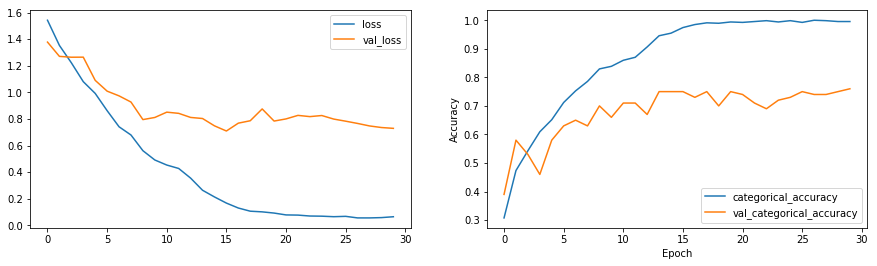

In [11]:
plot(history_model_cnn_lstm_6)

#### Model Conclusion:
Maxm Validation Accuracy: 75% <br>
Corresponding Training Accuracy: 94.3%

Reducing dropout for last two layers with reduced number of dense neurons has not improved model performance much.

### CNN_LSTM Model : model_cnn_lstm_7

Lets reduce one hidden layer

In [8]:
model_cnn_lstm_7 = Sequential()

model_cnn_lstm_7.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(20,120,120,3)))
model_cnn_lstm_7.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_7.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_7.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_7.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_7.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_7.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_7.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_7.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_7.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_cnn_lstm_7.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_7.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_7.add(TimeDistributed(Flatten()))

lstm_cells=64
dense_neurons=64
dropout=0.25
model_cnn_lstm_7.add(LSTM(lstm_cells))
model_cnn_lstm_7.add(Dropout(dropout))

model_cnn_lstm_7.add(Dense(dense_neurons,activation='relu'))
model_cnn_lstm_7.add(Dropout(dropout))

model_cnn_lstm_7.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model_cnn_lstm_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model_cnn_lstm_7.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 30, 30, 64)    18496     
__________

In [10]:
history_model_cnn_lstm_7 = train_model(model_cnn_lstm_7, 20,40, 20)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Epoch 1/20
17/17 [==============================] - 57s 3s/step - loss: 1.2556 - categorical_accuracy: 0.5080 - val_loss: 1.2190 - val_categorical_accuracy: 0.5700

Epoch 00001: val_loss improved from inf to 1.21901, saving model to model_init_2020-09-0915_58_34.121070/model-00001-1.25496-0.50980-1.21901-0.57000.h5
Epoch 2/20
17/17 [==============================] - 51s 3s/step - loss: 1.0805 - categorical_accuracy: 0.5800 - val_loss: 1.0578 - val_categorical_accuracy: 0.6000

Epoch 00002: val_loss improved from 1.21901 to 1.05784, saving model to model_init_2020-09-0915_58_34.121070/model-00002-1.08482-0.57617-1.05784-0.60000.h5
Epoch 3/20
17/17 [==============================] - 50s 3s/step - loss: 0.9672 - categorical_accuracy: 0.6344 - val_loss: 0.9377 - val_categorical_accuracy: 0.6500

Epoch 00003: val_loss improved from 1.05784 to 0.93772, saving model to model_init_2020-09-0915_58_34.121070/model-00003-0.96789-0.63499-0.93772-0.65000.h5
Epoch 4/20
17/17 [=======================

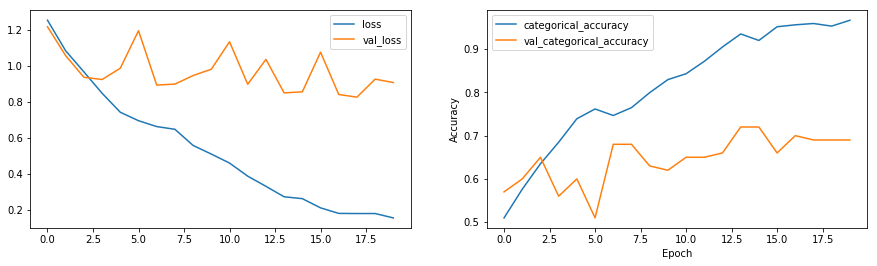

In [11]:
plot(history_model_cnn_lstm_7)

#### Model Conclusion:
Maxm Validation Accuracy: 72% <br>
Corresponding Training Accuracy: 92%

Reducing one hidden layer and reducing batch size to 40 did not improve the performance much. 

### CNN_LSTM Model : model_cnn_lstm_8

Introducing more dropouts in last few layers, and increasing number of epochs

In [12]:
model_cnn_lstm_8 = Sequential()

model_cnn_lstm_8.add(TimeDistributed(Conv2D(16, (2, 2) , padding='same', activation='relu'),
                          input_shape=(20,120,120,3)))
model_cnn_lstm_8.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_8.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_8.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same', activation='relu')))
model_cnn_lstm_8.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_8.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_8.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
model_cnn_lstm_8.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_8.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_8.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='relu')))
model_cnn_lstm_8.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_8.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_lstm_8.add(Dropout(0.3))

model_cnn_lstm_8.add(TimeDistributed(Conv2D(256, (2, 2) , padding='same', activation='relu')))
model_cnn_lstm_8.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_8.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_lstm_8.add(Dropout(0.3))

model_cnn_lstm_8.add(TimeDistributed(Flatten()))

lstm_cells=128
dense_neurons=128
dropout=0.5
model_cnn_lstm_8.add(LSTM(lstm_cells))
model_cnn_lstm_8.add(Dropout(dropout))

model_cnn_lstm_8.add(Dense(dense_neurons,activation='relu'))
model_cnn_lstm_8.add(Dropout(dropout))

model_cnn_lstm_8.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.0002)
model_cnn_lstm_8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model_cnn_lstm_8.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 20, 120, 120, 16)  208       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_16 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 20, 60, 60, 32)    2080      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 20, 30, 30, 64)    8256      
__________

In [14]:
history_model_cnn_lstm_8 = train_model(model_cnn_lstm_8, 20,80, 35)

Epoch 1/35


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


9/9 [==============================] - 55s 6s/step - loss: 0.7924 - categorical_accuracy: 0.6970 - val_loss: 0.8105 - val_categorical_accuracy: 0.7100

Epoch 00001: val_loss improved from inf to 0.81046, saving model to model_init_2020-09-0916_57_46.330584/model-00001-0.78610-0.69382-0.81046-0.71000.h5
Epoch 2/35
9/9 [==============================] - 45s 5s/step - loss: 0.7426 - categorical_accuracy: 0.7105 - val_loss: 0.8061 - val_categorical_accuracy: 0.7100

Epoch 00002: val_loss improved from 0.81046 to 0.80605, saving model to model_init_2020-09-0916_57_46.330584/model-00002-0.76132-0.69834-0.80605-0.71000.h5
Epoch 3/35
9/9 [==============================] - 45s 5s/step - loss: 0.7343 - categorical_accuracy: 0.7215 - val_loss: 0.8091 - val_categorical_accuracy: 0.7200

Epoch 00003: val_loss did not improve from 0.80605
Epoch 4/35
9/9 [==============================] - 46s 5s/step - loss: 0.7188 - categorical_accuracy: 0.7295 - val_loss: 0.7973 - val_categorical_accuracy: 0.7300



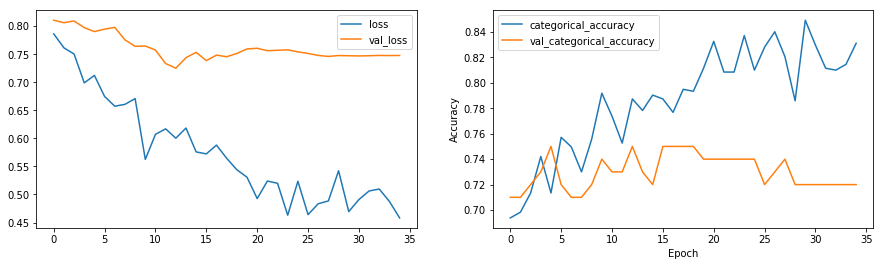

In [15]:
plot(history_model_cnn_lstm_8)

#### Model Conclusion:
Maxm Validation Accuracy: 75% <br>
Corresponding Training Accuracy: 79%

Increasing epochs, adding more dropout to the hidden layers, with increased Lstm Cells and Dense Neurons has a better model performance, but the training accuracy has deteriorated.

### CNN_LSTM Model : model_cnn_lstm_9

Changing filter size

In [18]:
model_cnn_lstm_9 = Sequential()

model_cnn_lstm_9.add(TimeDistributed(Conv2D(16, (2, 2) , padding='same', activation='relu'),
                          input_shape=(20,120,120,3)))
model_cnn_lstm_9.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_9.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_9.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same', activation='relu')))
model_cnn_lstm_9.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_9.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_9.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
model_cnn_lstm_9.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_9.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_9.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='relu')))
model_cnn_lstm_9.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_9.add(TimeDistributed(MaxPooling2D((2, 2))))

model_cnn_lstm_9.add(TimeDistributed(Conv2D(256, (2, 2) , padding='same', activation='relu')))
model_cnn_lstm_9.add(TimeDistributed(BatchNormalization()))
model_cnn_lstm_9.add(TimeDistributed(MaxPooling2D((2, 2))))
model_cnn_lstm_9.add(Dropout(0.25))

model_cnn_lstm_9.add(TimeDistributed(Flatten()))

lstm_cells=128
dense_neurons=64
dropout=0.4
model_cnn_lstm_9.add(LSTM(lstm_cells))
model_cnn_lstm_9.add(Dropout(dropout))

model_cnn_lstm_9.add(Dense(dense_neurons,activation='relu'))
model_cnn_lstm_9.add(Dropout(dropout))

model_cnn_lstm_9.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model_cnn_lstm_9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model_cnn_lstm_9.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_46 (TimeDis (None, 20, 120, 120, 16)  208       
_________________________________________________________________
time_distributed_47 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_48 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_49 (TimeDis (None, 20, 60, 60, 32)    2080      
_________________________________________________________________
time_distributed_50 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_51 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_52 (TimeDis (None, 20, 30, 30, 64)    8256      
__________

In [19]:
history_model_cnn_rnn_4_ = train_model(model_cnn_rnn_4_, 20,40, 30)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


17/17 [==============================] - 53s 3s/step - loss: 1.5520 - categorical_accuracy: 0.3318 - val_loss: 1.3396 - val_categorical_accuracy: 0.4600

Epoch 00001: val_loss improved from inf to 1.33964, saving model to model_init_2020-09-0917_37_58.728706/model-00001-1.55436-0.33032-1.33964-0.46000.h5
Epoch 2/30
17/17 [==============================] - 43s 3s/step - loss: 1.3610 - categorical_accuracy: 0.4035 - val_loss: 1.2102 - val_categorical_accuracy: 0.5100

Epoch 00002: val_loss improved from 1.33964 to 1.21024, saving model to model_init_2020-09-0917_37_58.728706/model-00002-1.36306-0.40271-1.21024-0.51000.h5
Epoch 3/30
17/17 [==============================] - 45s 3s/step - loss: 1.2585 - categorical_accuracy: 0.4397 - val_loss: 1.1351 - val_categorical_accuracy: 0.5900

Epoch 00003: val_loss improved from 1.21024 to 1.13505, saving model to model_init_2020-09-0917_37_58.728706/model-00003-1.26054-0.44193-1.13505-0.59000.h5
Epoch 4/30
17/17 [==============================] - 

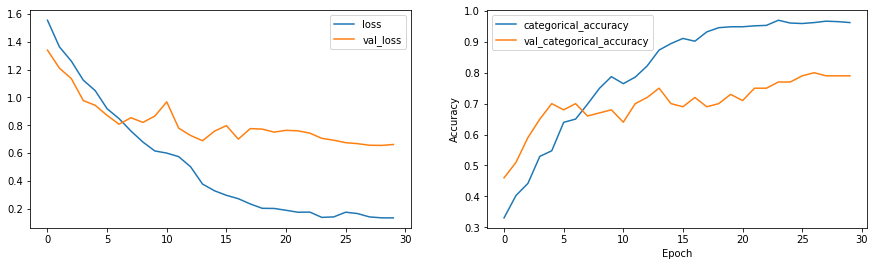

In [20]:
plot(history_model_cnn_lstm_9)

#### Results-
Maxm Validation Accuracy: 80% <br>
Corresponding Training Accuracy: 96%

Reduced Filter size, but the model is still overfitting.

### Transfer Learning

We can also try transfer learning on pre trained models, few such models available in Keras are as follows:

Ref: https://keras.io/api/applications/#finetune-inceptionv3-on-a-new-set-of-classes


|       Model       |  Size  | Top-1 Accuracy | Top-5 Accuracy | Parameters  | Depth |
|-------------------|--------|----------------|----------------|-------------|-------|
| Xception          | 88 MB  |          0.790 |          0.945 |  22,910,480 |   126 |
| VGG16             | 528 MB |          0.713 |          0.901 | 138,357,544 |    23 |
| VGG19             | 549 MB |          0.713 |          0.900 | 143,667,240 |    26 |
| ResNet50          | 98 MB  |          0.749 |          0.921 |  25,636,712 |     - |
| ResNet101         | 171 MB |          0.764 |          0.928 |  44,707,176 |     - |
| ResNet152         | 232 MB |          0.766 |          0.931 |  60,419,944 |     - |
| ResNet50V2        | 98 MB  |          0.760 |          0.930 |  25,613,800 |     - |
| ResNet101V2       | 171 MB |          0.772 |          0.938 |  44,675,560 |     - |
| ResNet152V2       | 232 MB |          0.780 |          0.942 |  60,380,648 |     - |
| InceptionV3       | 92 MB  |          0.779 |          0.937 |  23,851,784 |   159 |
| InceptionResNetV2 | 215 MB |          0.803 |          0.953 |  55,873,736 |   572 |
| MobileNet         | 16 MB  |          0.704 |          0.895 |   4,253,864 |    88 |
| MobileNetV2       | 14 MB  |          0.713 |          0.901 |   3,538,984 |    88 |
| DenseNet121       | 33 MB  |          0.750 |          0.923 |   8,062,504 |   121 |
| DenseNet169       | 57 MB  |          0.762 |          0.932 |  14,307,880 |   169 |
| DenseNet201       | 80 MB  |          0.773 |          0.936 |  20,242,984 |   201 |
| NASNetMobile      | 23 MB  |          0.744 |          0.919 |   5,326,716 |     - |
| NASNetLarge       | 343 MB |          0.825 |          0.960 |  88,949,818 |     - |
| EfficientNetB0    | 29 MB  |              - |              - |   5,330,571 |     - |
| EfficientNetB1    | 31 MB  |              - |              - |   7,856,239 |     - |
| EfficientNetB2    | 36 MB  |              - |              - |   9,177,569 |     - |
| EfficientNetB3    | 48 MB  |              - |              - |  12,320,535 |     - |
| EfficientNetB4    | 75 MB  |              - |              - |  19,466,823 |     - |
| EfficientNetB5    | 118 MB |              - |              - |  30,562,527 |     - |
| EfficientNetB6    | 166 MB |              - |              - |  43,265,143 |     - |
| EfficientNetB7    | 256 MB |              - |              - |  66,658,687 |     - |

In our case as the model is supposed to run in a limited footprint scenario we will be leveraging the MobileNetV1/MobileNetV2 models

In [24]:
from keras.applications import MobileNetV2
from keras.applications import MobileNet

#### MobileNetV1

In [25]:
mobilenet_transfer = MobileNet(weights='imagenet', include_top=False)

        
model_mobilenet = Sequential()
model_mobilenet.add(TimeDistributed(mobilenet_transfer,input_shape=(16,120,120,3)))
        
        
for layer in model.layers:
    layer.trainable = False
        
        
model_mobilenet.add(TimeDistributed(BatchNormalization()))
model_mobilenet.add(TimeDistributed(MaxPooling2D((2, 2))))
model_mobilenet.add(TimeDistributed(Flatten()))

model_mobilenet.add(LSTM(128))
model_mobilenet.add(Dropout(0.25))
        
model_mobilenet.add(Dense(128,activation='relu'))
model_mobilenet.add(Dropout(0.25))
        
model_mobilenet.add(Dense(5, activation='softmax'))
        
        
optimiser = optimizers.Adam()
model_mobilenet.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_mobilenet.summary())

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_14 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (D

In [26]:
history_model_mobile_net = train_model(model_mobilenet, 16,10, 20)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 57s 856ms/step - loss: 1.3597 - categorical_accuracy: 0.4304 - val_loss: 0.9172 - val_categorical_accuracy: 0.6900

Epoch 00001: val_loss improved from inf to 0.91717, saving model to model_init_2020-09-0511_11_54.977927/model-00001-1.36058-0.43137-0.91717-0.69000.h5
Epoch 2/20
67/67 [==============================] - 40s 600ms/step - loss: 0.7463 - categorical_accuracy: 0.7006 - val_loss: 0.4757 - val_categorical_accuracy: 0.8400

Epoch 00002: val_loss improved from 0.91717 to 0.47565, saving model to model_init_2020-09-0511_11_54.977927/model-00002-0.73747-0.70437-0.47565-0.84000.h5
Epoch 3/20
67/67 [==============================] - 43s 641ms/step - loss: 0.5993 - categorical_accuracy: 0.7861 - val_loss: 0.4111 - val_categorical_accuracy: 0.8200

Epoch 00003: val_loss improved from 0.47565 to 0.41114, saving model to model_init_2020-09-0511_11_54.977927/model-00003-0.59945-0.78733-0.41114-0.82000.h5
Epoch 4/20
67/67 [=========================

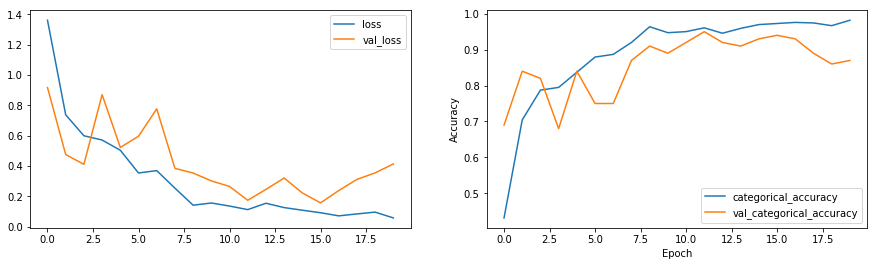

In [27]:
plot(history_model_mobile_net)

#### Model conclusion:
1. The model results are as follows: val accuracy --> 0.95 corresponding training accuracy --> 0.95
2. The model has generalized well as the validaation and training accuracies are pretty similar

#### MobileNetV2

In [17]:
mobilenet_transfer = MobileNetV2(weights='imagenet', include_top=False)

        
model_mobilenetv2 = Sequential()
model_mobilenetv2.add(TimeDistributed(mobilenet_transfer,input_shape=(16,120,120,3)))
        
        
for layer in model.layers:
    layer.trainable = False
        
        
model_mobilenetv2.add(TimeDistributed(BatchNormalization()))
model_mobilenetv2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_mobilenetv2.add(TimeDistributed(Flatten()))

model_mobilenetv2.add(LSTM(128))
model_mobilenetv2.add(Dropout(0.25))
        
model_mobilenetv2.add(Dense(128,activation='relu'))
model_mobilenetv2.add(Dropout(0.25))
        
model_mobilenetv2.add(Dense(5, activation='softmax'))
        
        
optimiser = optimizers.Adam()
model_mobilenetv2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_mobilenetv2.summary())

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:310: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 16, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_10 (TimeDis (None, 16, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 16, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 16, 5120)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               2687488   
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
__________

In [22]:
history_model_mobile_netv2 = train_model(model_mobilenetv2, 16,10, 20)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 53s 790ms/step - loss: 1.3638 - categorical_accuracy: 0.4263 - val_loss: 1.2800 - val_categorical_accuracy: 0.4900

Epoch 00001: val_loss improved from inf to 1.28004, saving model to model_init_2020-09-0510_53_00.423906/model-00001-1.37069-0.42383-1.28004-0.49000.h5
Epoch 2/20
67/67 [==============================] - 48s 719ms/step - loss: 0.9725 - categorical_accuracy: 0.6259 - val_loss: 1.3742 - val_categorical_accuracy: 0.5400

Epoch 00002: val_loss did not improve from 1.28004
Epoch 3/20
67/67 [==============================] - 48s 722ms/step - loss: 0.9071 - categorical_accuracy: 0.6517 - val_loss: 1.3694 - val_categorical_accuracy: 0.4800

Epoch 00003: val_loss did not improve from 1.28004
Epoch 4/20
67/67 [==============================] - 48s 720ms/step - loss: 0.7793 - categorical_accuracy: 0.6876 - val_loss: 1.3053 - val_categorical_accuracy: 0.5600

Epoch 00004: val_loss did not improve from 1.28004
Epoch 5/20
67/67 [================

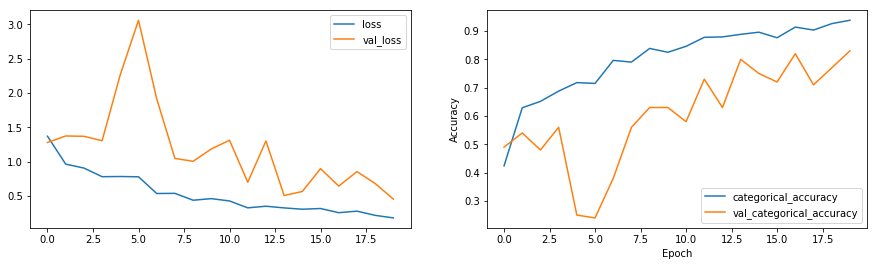

In [23]:
plot(history_model_mobile_netv2)

#### Model conclusion:
1. The model results are as follows: val accuracy --> 0.83 corresponding training accuracy --> 0.93
2. The model accuracy is fluctuating a lot and also there is slight overfitting